# Domain-Aware UI/UX Reviewer Agent: Custom Tools with Retry and Fallback


*Notebook by [Mayank Laddha](https://www.linkedin.com/in/mayankladdha31/)*

In this notebook, we'll build an agent to analyze a landing page using both desktop and mobile views. We define simple, optional tools to obtain readability scores, HTML structure, and performance-related data as needed. We also extend the Tool class to implement retry and fallback mechanisms.

Our stack:
- [Haystack Agentic framework](https://github.com/deepset-ai/haystack) -  to build our agent
- Playwright - for taking screenshots
- Beautifulsoup4 - for parsing html
- Textstat - for calculating text readability

## Setup

First, we'll install all the necessary dependencies:

In [1]:
!pip install playwright textstat haystack-ai beautifulsoup4 requests
!playwright install --with-deps chromium

Installing dependencies...
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 3,632 B in 1s (4,297 B/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-freefont-ttf is a

Add credentials for OpenAI API

In [2]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [3]:
import textstat
from bs4 import BeautifulSoup
from collections import Counter
import base64
import json
from playwright.async_api import async_playwright
from haystack.components.agents import Agent
from haystack.components.generators.chat import OpenAIChatGenerator
from haystack.dataclasses import ChatMessage,ImageContent
from haystack.tools import Tool
from haystack.tools.errors import ToolInvocationError
from haystack.utils.callable_serialization import deserialize_callable, serialize_callable
from haystack.components.generators.utils import print_streaming_chunk
from PIL import Image
from io import BytesIO,StringIO
import base64
import time
from typing import Any, Callable
from IPython.display import display,Markdown,Image as IPyImage
import inspect
import requests
import pprint
import logging


SHARED_DATA = {}
logger = logging.getLogger(__name__)
log_buffer = StringIO()
handler = logging.StreamHandler(log_buffer)
handler.setLevel(logging.WARNING)
logger.addHandler(handler)

## Tools and utility functions

Let's define a function to get desktop and mobile screenshots along with the html using playwright

In [4]:
async def capture_page(url:str):
    screenshots_b64 = []

    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        await page.add_style_tag(
            content="* { animation: none !important; transition: none !important; }"
        )

        await page.goto(url, wait_until="domcontentloaded", timeout=30000)

        viewports = {
            "desktop": (1920, 1080),
            "mobile": (375, 812)
        }

        for name, (w, h) in viewports.items():
            await page.set_viewport_size({"width": w, "height": h})

            img_bytes = await page.screenshot(
                full_page=True,
                type="png"
            )

            screenshots_b64.append(base64.b64encode(img_bytes).decode("utf-8"))

        html = await page.content()

        await browser.close()

    return screenshots_b64, html


Custom tool with retry and fallback

This `CustomTool` extends Haystack’s `Tool` to add **retry logic** and a **fallback mechanism**.

- Tools can fail for many practical reasons(unstable networks, unreliable APIs)
- Fallback functions often **do not share the exact same signature** as the main tool.
- We want fallbacks to:
  - Reuse tool inputs when possible
  - Accept a **subset of parameters** or **no parameters**


In [5]:
from dataclasses import dataclass
from typing import Callable, Any

@dataclass
class CustomTool(Tool):
    retry: int = 0
    fallback_function: Callable | None = None

    def _invoke_fallback(self, **kwargs: Any) -> Any:
        fn = self.fallback_function

        sig = inspect.signature(fn)

        if any(p.kind == p.VAR_KEYWORD for p in sig.parameters.values()):
            return fn(**kwargs)

        filtered = {
            k: v for k, v in kwargs.items()
            if k in sig.parameters
        }

        return fn(**filtered)


    def invoke(self, **kwargs: Any) -> Any:
        last_error = None

        for attempt in range(self.retry + 1):
            try:
                return self.function(**kwargs)
            except Exception as e:
                last_error = e
                if attempt < self.retry:
                    continue
                break

        if self.fallback_function is not None:
            logger.warning(
                "Tool `%s` failed after %d attempts. Using fallback function. Error: %s",
                self.name,
                self.retry + 1,
                last_error,
            )
            try:
                return self._invoke_fallback(**kwargs)
            except Exception as fallback_error:
                raise ToolInvocationError(
                    f"Tool `{self.name}` failed after {self.retry + 1} attempts "
                    f"and fallback also failed. "
                    f"Main error: {last_error}, Fallback error: {fallback_error}",
                    tool_name=self.name,
                ) from fallback_error

        raise ToolInvocationError(
            f"Tool `{self.name}` failed after {self.retry + 1} attempts. "
            f"Last error: {last_error}",
            tool_name=self.name,
        ) from last_error


    def to_dict(self) -> dict[str, Any]:
        base = super().to_dict()
        data = base["data"]

        data["retry"] = self.retry

        if self.fallback_function is not None:
            data["fallback_function"] = serialize_callable(self.fallback_function)
        else:
            data["fallback_function"] = None

        return base

    @classmethod
    def from_dict(cls, data: dict[str, Any]) -> "CustomTool":
        tool = super(CustomTool, cls).from_dict(data)

        if tool.fallback_function is not None:
            tool.fallback_function = deserialize_callable(tool.fallback_function)

        return tool



Let's define some tools:


*   html_analyzer - to get html structure
*   get_readability_score - to get readability score using textstat
*   get_performance - **we intentionally fail it to see if retry and fallback work**
*   get_perfromance_fallback - fallback for get_performance
*   image_weight_analyzer- get image count along with the size of the largest image




In [6]:

def html_analyzer(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    tags = [tag.name for tag in soup.find_all(True)]
    tag_counts = Counter(tags)

    def exists(tag):
        return tag_counts.get(tag, 0) > 0

    headings = {
        "h1_count": tag_counts.get("h1", 0),
        "h2_count": tag_counts.get("h2", 0),
        "h3_count": tag_counts.get("h3", 0)
    }

    max_depth = max(
        len(list(tag.parents))
        for tag in soup.find_all(True)
    )

    total_tags = len(tags)
    div_ratio = round(tag_counts.get("div", 0) / total_tags, 2) if total_tags else 0

    return json.dumps({
        "sections": {
            "header": exists("header"),
            "nav": exists("nav"),
            "main": exists("main"),
            "footer": exists("footer")
        },
        "headings": headings,
        "ctas": {
            "buttons": tag_counts.get("button", 0),
            "links": tag_counts.get("a", 0),
            "primary_cta_present": tag_counts.get("button", 0) > 0
        },
        "forms": {
            "form_count": tag_counts.get("form", 0),
            "input_count": tag_counts.get("input", 0)
        },
        "media": {
            "images": tag_counts.get("img", 0),
            "videos": tag_counts.get("video", 0)
        },
        "complexity": {
            "max_dom_depth": max_depth,
            "div_ratio": div_ratio
        }
    })


def get_readability_score(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    text = soup.get_text(separator="\n",strip=True)[:500]
    return "Flesch-Kincaid Grade: "+str(textstat.flesch_kincaid_grade(text))+"\n(This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.)"


def get_performance(url: str):
    r = requests.get(
        "https://www.invalid-url-for-testing.com",  # invalid domain to make it fail
        params={"url": url, "category": "performance"}
    )
    r.raise_for_status()


def get_performance_fallback(url: str):
    r = requests.get(url, timeout=10)
    html = r.text
    soup = BeautifulSoup(html, "html.parser")

    return json.dumps({
        "request_duration_ms": r.elapsed.total_seconds() * 1000,
        "html_kb": len(r.content) / 1024,
    })

def image_weight_analyzer(url:str):
    html = SHARED_DATA[url][1]
    soup = BeautifulSoup(html, "html.parser")
    images = soup.find_all("img")

    sizes = []
    for img in images:
        w = img.get("width")
        h = img.get("height")
        if w and h and w.isdigit() and h.isdigit():
            sizes.append(int(w) * int(h))

    return json.dumps({
        "image_count": len(images),
        "largest_image_pixels(w * h)": max(sizes) if sizes else 0
    })


Let's define our workflow:


* We get desktop and mobile screenshots along with the html using playwright using the function we defined earlier
* Let's define tools - We use **Tool** class to convert functionalities into tools. Note, we have set a retry and a fallback function for the CustomTool responsible for fetching performance-related data
* Define our agent, set the api_key for openai, we use gpt4o-mini for testing

We keep max_agent_steps = 5 but feel free to increase it.  

We hope to receive a feedback based on

* Content (how suitable and effective the content is for the given domain)
* Layout (layout quality, CTAs and ease of navigation)
* Visuals and Performance



In [7]:

async def workflow(url:str):
    web_data = await capture_page(url)
    SHARED_DATA[url] = web_data
    tools = [
        Tool(
            name="html_analyzer",
            description="Returns html structure of the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=html_analyzer
        ),
        Tool(
            name="get_readability_score",
            description="Returns readability score of the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=get_readability_score
        ),
        Tool(
            name="image_weight_analyzer",
            description="Returns image count and largest image size on the landing page.",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing page"}
                },
                "required": ["url"]
            },
            function=image_weight_analyzer
        ),
        CustomTool(
            name="performace",
            description="Returns largest contentful paint",
            parameters={
                "type": "object",
                "properties": {
                    "url": {"type": "string", "description": "url of the landing"}
                    },
                "required": ["url"]
            },
            function=get_performance,
            retry=1,
            fallback_function=get_performance_fallback
        ),
    ]

    agent = Agent(
        chat_generator=OpenAIChatGenerator(model="gpt-4o-mini",generation_kwargs={"max_completion_tokens":3000,"temperature":0.2}),
        tools=tools,
        max_agent_steps = 5,
        streaming_callback=print_streaming_chunk

    )

    prompt = f"""
    You are an expert in UI/UX. You are given desktop and mobile views, along with performance data, for a landing page. First, determine the domain based on the page content, and then analyze the landing page from a UI/UX perspective.

    Make sure to consider the domain during your analysis. For example, a finance website may have very different requirements compared to a travel website. Some websites require higher readability, while others should focus more on wonderful visuals and engagement and less on readability.

    Some websites need better performance, for some it might not be a priority.

    You are also provided with tools to:

    - analyze the HTML structure,

    - get perfromance related data,

    - extract image-related data, and

    - calculate a readability score.

    The use of these tools is optional. Decide which tools are needed and use them if they help you provide better feedback.

    Provide both positive and negative feedback on the following aspects, considering both desktop and mobile views:

    - Content (how suitable and effective the content is for the given domain)

    - Layout (layout quality, CTAs and ease of navigation)

    - Visuals (design, responsiveness, and visual quality, considering the domain)

    - Performance (only if applicable)

    - Actionable improvements

    Do not make up information. Speak like a ui/ux expert using simple informal english. Return the feedback in Markdown format.
    URL: {url}
    """
    screenshots = web_data[0]
    desktop_content = ImageContent(base64_image=f"{screenshots[0]}",detail="low")
    mobile_content =  ImageContent(base64_image=f"{screenshots[1]}",detail="low")
    result = agent.run(
        messages=[ChatMessage.from_user(content_parts=[prompt,desktop_content,mobile_content])]
    )
    feedback = result["messages"][-1].text
    tool_calls = [message.tool_calls for message in result["messages"] if message.tool_calls]
    tool_call_results = [message.tool_call_results for message in result["messages"] if message.tool_call_results]
    pil_images = [Image.open(BytesIO(base64.b64decode(screenshots[0]))),Image.open(BytesIO(base64.b64decode(screenshots[1])))]
    return feedback,pil_images, tool_calls, tool_call_results


## Let's run our agent and check results

We can directly await in colab as it already has an active asyncio event loop running in the background by default. No need to worry about 'await only allowed within async function' error. This step will take some time.

In [8]:
feedback,pil_images,tool_calls,tool_call_results = await workflow("https://visitors.now/")
logs = log_buffer.getvalue()
print("--- TOOL LOGS ---")
print(logs)
_ =log_buffer.truncate(0)   # remove all current content
_ =log_buffer.seek(0)

[TOOL CALL]
Tool: html_analyzer 
Arguments: {"url": "https://visitors.now/"}

[TOOL CALL]
Tool: performace 
Arguments: {"url": "https://visitors.now/"}

[TOOL CALL]
Tool: get_readability_score 
Arguments: {"url": "https://visitors.now/"}

[TOOL CALL]
Tool: image_weight_analyzer 
Arguments: {"url": "https://visitors.now/"}

[TOOL RESULT]
{"sections": {"header": true, "nav": true, "main": false, "footer": true}, "headings": {"h1_count": 1, "h2_count": 12, "h3_count": 18}, "ctas": {"buttons": 37, "links": 36, "primary_cta_present": true}, "forms": {"form_count": 0, "input_count": 0}, "media": {"images": 5, "videos": 0}, "complexity": {"max_dom_depth": 24, "div_ratio": 0.47}}



[TOOL RESULT]
{"request_duration_ms": 136.953, "html_kb": 159.4765625}

[TOOL RESULT]
Flesch-Kincaid Grade: 10.50820512820513
(This is a grade formula in that a score of 9.3 means that a ninth grader would be able to read the document.)

[TOOL RESULT]
{"image_count": 5, "largest_image_pixels(w * h)": 5184000}

[ASSISTANT]
# UI/UX Analysis of Visitors Now Landing Page

## Domain Overview
The website appears to be related to visitor analytics or tracking, likely aimed at businesses or individuals looking to understand their website traffic. This domain typically requires a balance of readability, clear visuals, and effective calls to action (CTAs) to engage users effectively.

## Content
### Positive Feedback:
- **Informative Headings**: The use of multiple headings (1 H1, 12 H2s, and 18 H3s) helps in organizing the content and guiding users through the information.
- **Clear CTAs**: With 37 buttons and 36 links, the page offers numerous opportunities for user engagement, which is esse

Let's check if screenshots were proper

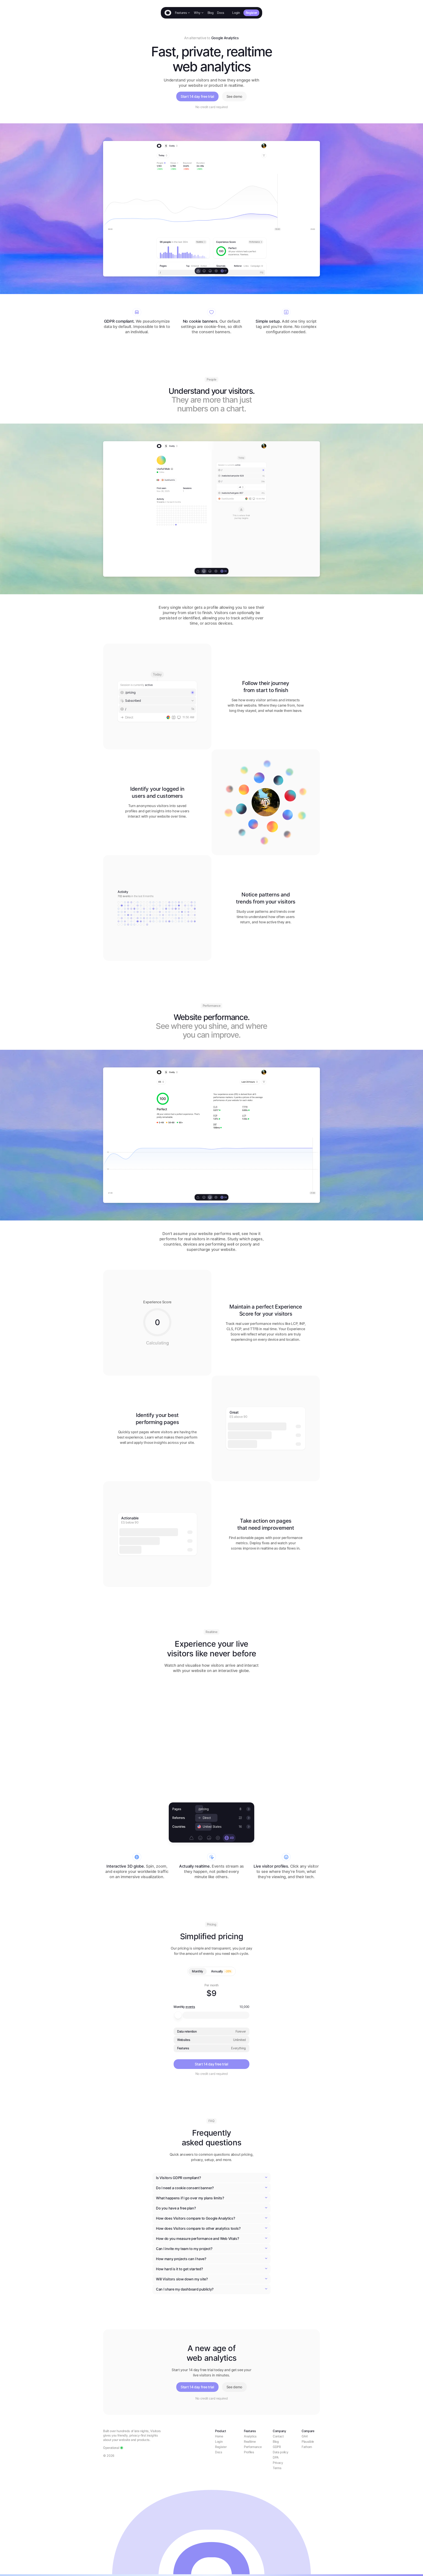

In [9]:
def display_preview(img, width=800):
    buf = BytesIO()
    img.save(buf, format="PNG")
    display(IPyImage(data=buf.getvalue(), width=width))

display_preview(pil_images[0])

## Feedback

In [10]:
Markdown(feedback)

# UI/UX Analysis of Visitors Now Landing Page

## Domain Overview
The website appears to be related to visitor analytics or tracking, likely aimed at businesses or individuals looking to understand their website traffic. This domain typically requires a balance of readability, clear visuals, and effective calls to action (CTAs) to engage users effectively.

## Content
### Positive Feedback:
- **Informative Headings**: The use of multiple headings (1 H1, 12 H2s, and 18 H3s) helps in organizing the content and guiding users through the information.
- **Clear CTAs**: With 37 buttons and 36 links, the page offers numerous opportunities for user engagement, which is essential for a service-oriented site.

### Negative Feedback:
- **Readability**: The Flesch-Kincaid Grade level is around 10.5, which might be a bit high for some users. Simplifying the language could make the content more accessible.
- **Lack of Forms**: There are no forms for user input, which might limit user interaction, especially for a service that likely requires user data.

## Layout
### Positive Feedback:
- **Structured Layout**: The presence of a header, navigation, and footer provides a clear structure, making it easier for users to navigate.
- **Primary CTA**: The presence of a primary CTA is crucial for driving user actions.

### Negative Feedback:
- **Complexity**: The DOM depth of 24 suggests a complex structure, which might slow down rendering and confuse users. Simplifying the layout could improve user experience.
- **Navigation**: While the navigation is present, it could be more intuitive. Consider adding a sticky menu or breadcrumbs for easier navigation.

## Visuals
### Positive Feedback:
- **Visual Engagement**: The use of images (5 total) adds visual interest and breaks up text, making the page more engaging.
- **Responsive Design**: The layout appears to adapt well to different screen sizes, which is essential for mobile users.

### Negative Feedback:
- **Image Quality**: The largest image size is quite large (5,184,000 pixels), which may affect loading times. Optimizing images for web use could enhance performance.
- **Visual Consistency**: Ensure that the color scheme and typography are consistent throughout the page to strengthen branding.

## Performance
### Positive Feedback:
- **Request Duration**: The page loads relatively quickly (137 ms), which is good for user retention.

### Negative Feedback:
- **Potential for Improvement**: While the initial load time is decent, further optimizations (like image compression) could enhance performance, especially for mobile users.

## Actionable Improvements
1. **Simplify Language**: Lower the readability grade by using simpler language to make the content more accessible.
2. **Optimize Images**: Compress images to improve loading times and overall performance.
3. **Enhance Navigation**: Consider adding sticky navigation or breadcrumbs to improve user experience.
4. **Add User Interaction Forms**: Introduce forms to capture user data and enhance engagement.
5. **Streamline DOM Structure**: Reduce the complexity of the DOM to improve rendering speed and user experience.

By addressing these aspects, the landing page can better serve its audience and achieve its goals more effectively.

## Tool calls and results

In [11]:
pprint.pprint(tool_calls)

[[ToolCall(tool_name='html_analyzer',
           arguments={'url': 'https://visitors.now/'},
           id='call_cXhredWjy4qOBNI1T1qUSXhS',
           extra=None),
  ToolCall(tool_name='performace',
           arguments={'url': 'https://visitors.now/'},
           id='call_oOenXnjFrIkSYxDAcUFefGYN',
           extra=None),
  ToolCall(tool_name='get_readability_score',
           arguments={'url': 'https://visitors.now/'},
           id='call_rjzBSnRVdY9QAxlPYm3hbFgA',
           extra=None),
  ToolCall(tool_name='image_weight_analyzer',
           arguments={'url': 'https://visitors.now/'},
           id='call_zc6LKDmFPryCo5QPtMRnz2ni',
           extra=None)]]


In [12]:
pprint.pprint(tool_call_results)

[[ToolCallResult(result='{"sections": {"header": true, "nav": true, "main": '
                        'false, "footer": true}, "headings": {"h1_count": 1, '
                        '"h2_count": 12, "h3_count": 18}, "ctas": {"buttons": '
                        '37, "links": 36, "primary_cta_present": true}, '
                        '"forms": {"form_count": 0, "input_count": 0}, '
                        '"media": {"images": 5, "videos": 0}, "complexity": '
                        '{"max_dom_depth": 24, "div_ratio": 0.47}}',
                 origin=ToolCall(tool_name='html_analyzer',
                                 arguments={'url': 'https://visitors.now/'},
                                 id='call_cXhredWjy4qOBNI1T1qUSXhS',
                                 extra=None),
                 error=False)],
 [ToolCallResult(result='{"request_duration_ms": 136.953, "html_kb": '
                        '159.4765625}',
                 origin=ToolCall(tool_name='performace',
                 

As we can see, it used fallback function as expected.

Want to test this with a UI? Check out the demo:

[Demo](https://github.com/maylad31/uiux_reviewer_agent)